Archive:  liberation.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of liberation.zip or
        liberation.zip.zip, and cannot find liberation.zip.ZIP, period.


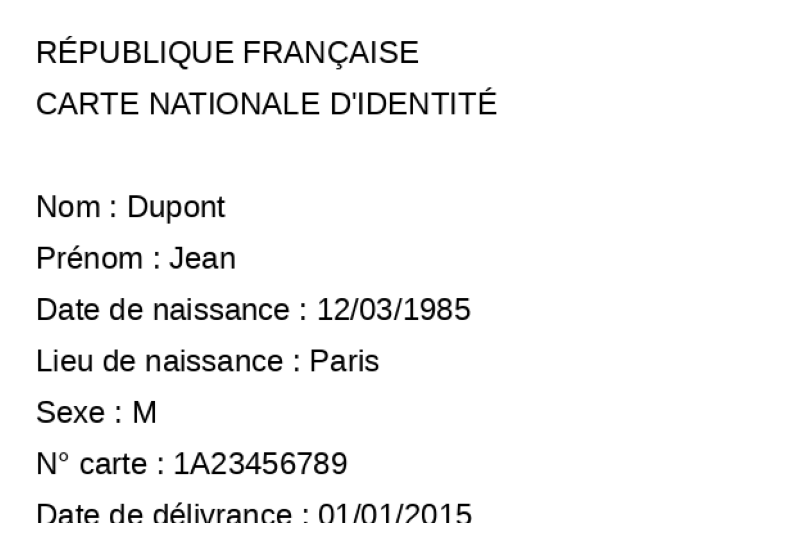


Extracted fields:
Nom: Dupont (confidence: 1.00)
Prénom: Jean (confidence: 0.97)
Date de naissance: 12/03/1985 (confidence: 0.68)
Lieu de naissance: Paris (confidence: 1.00)
Sexe: M (confidence: 1.00)
Date de délivrance: 01/01/201 (confidence: 0.77)


In [19]:
# Install dependencies
!pip install -q easyocr pillow

# Download LiberationSans font for French accented chars
!wget -q https://github.com/liberationfonts/liberation-fonts/files/1804345/LiberationSans-Regular.ttf.zip -O liberation.zip
!unzip -o liberation.zip LiberationSans-Regular.ttf

import easyocr
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

# Load LiberationSans font
font_path = "LiberationSans-Regular.ttf"
font = ImageFont.truetype(font_path, 24)

# Create synthetic French ID card image (600x400 for full display)
width, height = 600, 400
img = Image.new('RGB', (width, height), color='white')
draw = ImageDraw.Draw(img)

text_lines = [
    "RÉPUBLIQUE FRANÇAISE",
    "CARTE NATIONALE D'IDENTITÉ",
    "",
    "Nom : Dupont",
    "Prénom : Jean",
    "Date de naissance : 12/03/1985",
    "Lieu de naissance : Paris",
    "Sexe : M",
    "N° carte : 1A23456789",
    "Date de délivrance : 01/01/2015",
    "Date d'expiration : 01/01/2025"
]

y_text = 20
for line in text_lines:
    draw.text((20, y_text), line, font=font, fill='black')
    y_text += 40

# Display the image fully without axis
plt.figure(figsize=(8, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.tight_layout()
plt.show()

# Run OCR with EasyOCR (French language)
reader = easyocr.Reader(['fr'], gpu=False)
img_np = np.array(img)
result = reader.readtext(img_np)

# Extraction logic for fields (label and value)
fields_labels = [
    "Nom", "Prénom", "Date de naissance", "Lieu de naissance",
    "Sexe", "N° carte", "Numéro de carte", "Date de délivrance", "Date d'expiration"
]

fields = {}
current_key = None

for bbox, text, prob in result:
    text_clean = text.strip()
    matched_label = None
    for label in fields_labels:
        # Match exact label or label followed by colon
        if text_clean.lower() == label.lower() or text_clean.lower().startswith(label.lower() + ":"):
            matched_label = label
            break

    if matched_label:
        # If label and value on same line (with colon)
        if ':' in text_clean:
            value = text_clean.split(':', 1)[1].strip()
            if value:
                fields[matched_label] = {'value': value, 'confidence': prob}
            current_key = None
        else:
            # Label only line, expect next line as value
            current_key = matched_label
    else:
        # If previous line was label only, assign this as its value
        if current_key and current_key not in fields:
            fields[current_key] = {'value': text_clean, 'confidence': prob}
            current_key = None
        else:
            current_key = None

# Print extracted fields cleanly
print("\nExtracted fields:")
for k, info in fields.items():
    print(f"{k}: {info['value']} (confidence: {info['confidence']:.2f})")
